In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (14.0, 5.0)
matplotlib.rcParams['axes.titlesize'] = 18

Before reading on, you may want to look at the pyspark script used to create this data.

Let's import the data and get an idea of what it looks like.

In [74]:
change1415 = pd.read_csv('change1415.csv')
change1516 = pd.read_csv('change1516.csv')
change1617 = pd.read_csv('change1617.csv')
change1415.head()

,StateCode,Age,avg(IndividualRate)_2014,avg(IndividualTobaccoRate)_2014,avg(Couple)_2014,avg(PrimarySubscriberAndOneDependent)_2014,avg(PrimarySubscriberAndTwoDependents)_2014,avg(PrimarySubscriberAndThreeOrMoreDependents)_2014,avg(CoupleAndOneDependent)_2014,avg(CoupleAndTwoDependents)_2014,...,avg(CoupleAndThreeOrMoreDependents)_2015,change_avg(IndividualRate),change_avg(IndividualTobaccoRate),change_avg(Couple),change_avg(PrimarySubscriberAndOneDependent),change_avg(PrimarySubscriberAndTwoDependents),change_avg(PrimarySubscriberAndThreeOrMoreDependents),change_avg(CoupleAndOneDependent),change_avg(CoupleAndTwoDependents),change_avg(CoupleAndThreeOrMoreDependents)
0,SC,Family Option,26.568579,NaN,45.970598,45.162818,63.757422,87.464759,64.564371,83.159076,...,112.351739,23.154725,NaN,14.603655,15.627532,23.381819,9.671423,22.557723,14.351529,5.133149
1,TX,29,188.201377,314.890420,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,7.735783,-6.384138,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,WI,42,388.225208,478.267213,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-3.484193,-3.680138,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IN,62,799.026427,1332.284679,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-55.742872,-25.436129,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PA,26,229.106052,280.519724,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-9.239450,-0.988973,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
change1617[(change1617.Age == '25') & (change1617.StateCode == "SC")]['avg(IndividualRate)_2017']

1163    274.193116
Name: avg(IndividualRate)_2017, dtype: float64

It'll be difficult to work with some of the column names, so let's get rid of the parentheses and 'avg' in the change columns.

In [77]:
import re
toMatch = re.compile('\(\w+\)')
renameCols = {col:  col.replace('(', "").replace(')', "").replace('avg', "") for col in change1415.columns  if 'change' in col}
change1415 = change1415.rename(columns=renameCols)
change1516 = change1516.rename(columns=renameCols)
change1617 = change1617.rename(columns=renameCols)

Because we're just looking at individual rates, we'll also remove any rows that fall into the family option age group.

In [14]:
change1415 = change1415[change1415.Age != 'Family Option']
change1516 = change1516[change1516.Age != 'Family Option']
change1617 = change1617[change1617.Age != 'Family Option']

## Rates By Age

Let's first examine how rates have changed regardless of state. We'll average the change in rates across all the states, then plot them 

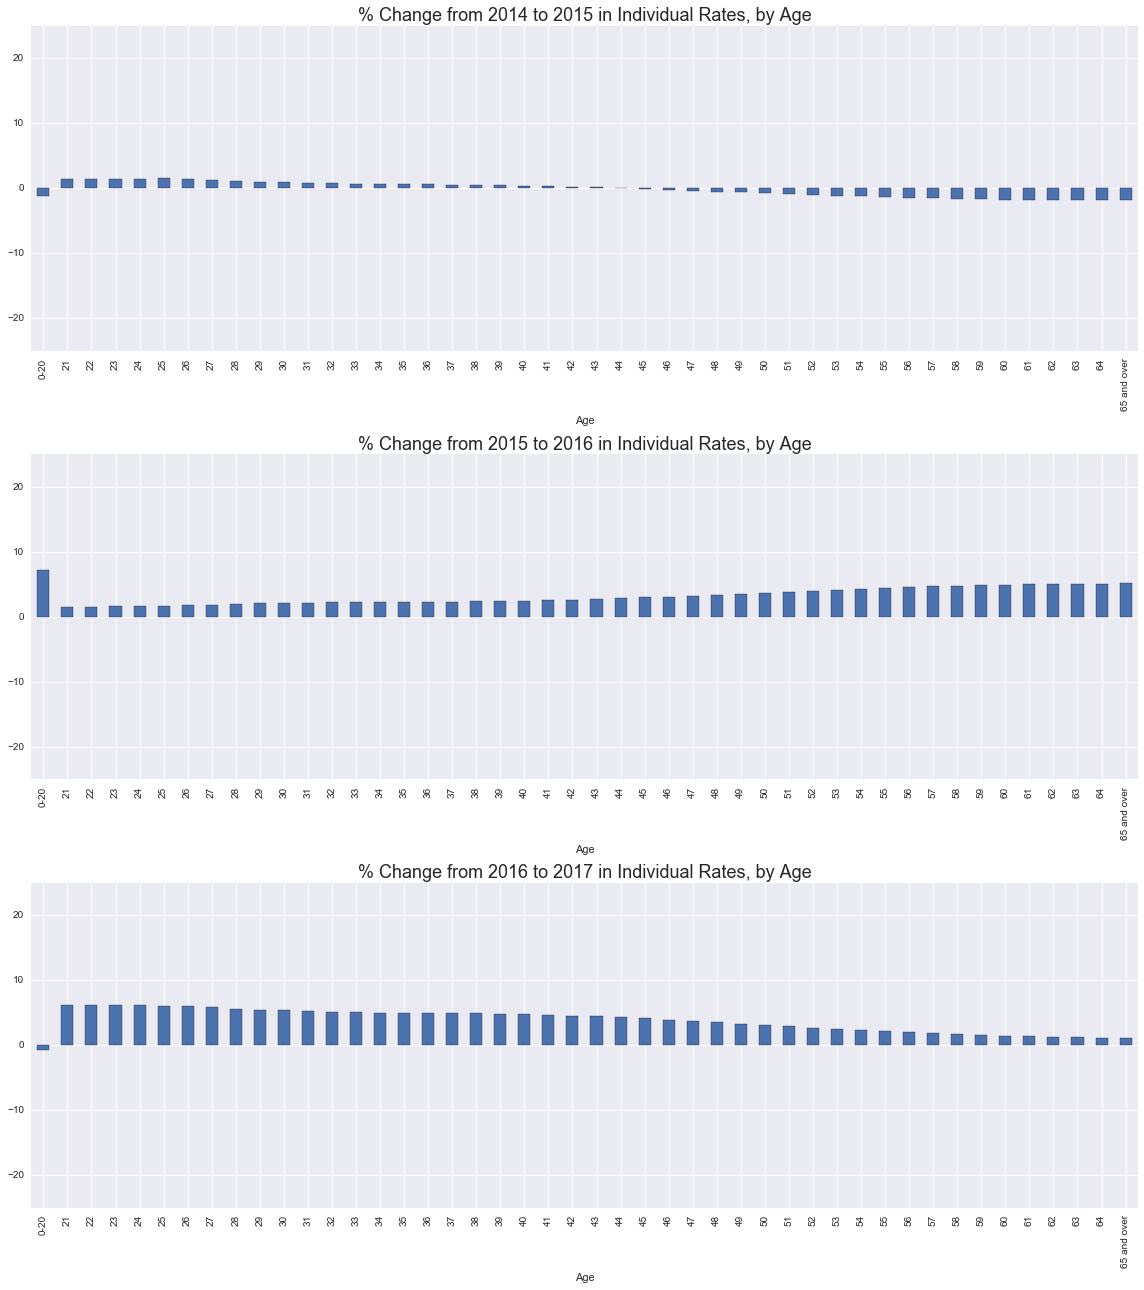

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(16,18))

change1415.groupby(['Age'])['change_IndividualRate'].mean().plot.bar(ax=ax1)
ax1.set_title('% Change from 2014 to 2015 in Individual Rates, by Age')
ax1.set_ylim((-25,25))

change1516.groupby(['Age'])['change_IndividualRate'].mean().plot.bar(ax=ax2)
ax2.set_title('% Change from 2015 to 2016 in Individual Rates, by Age')
ax2.set_ylim((-25,25))

change1617.groupby(['Age'])['change_IndividualRate'].mean().plot.bar(ax=ax3)
ax3.set_title('% Change from 2016 to 2017 in Individual Rates, by Age')
ax3.set_ylim((-25,25))

fig.tight_layout()

Above, we see small changes from 2014 to 2015, with younger ages showing an increase and older ages a decrease. The other years saw almost all increases between 0-10%.

## Rates By State

Now let's see how individual rates varied by state. To make plotting easier, let's concatenate the change dataframes.

In [16]:
change1415['years'] = '2014-2015'
change1516['years'] = '2015-2016'
change1617['years'] = '2016-2017'

allYears = pd.concat([change1415, change1516, change1617])

Now we'll plot in average rate changes for all age groups for each state.

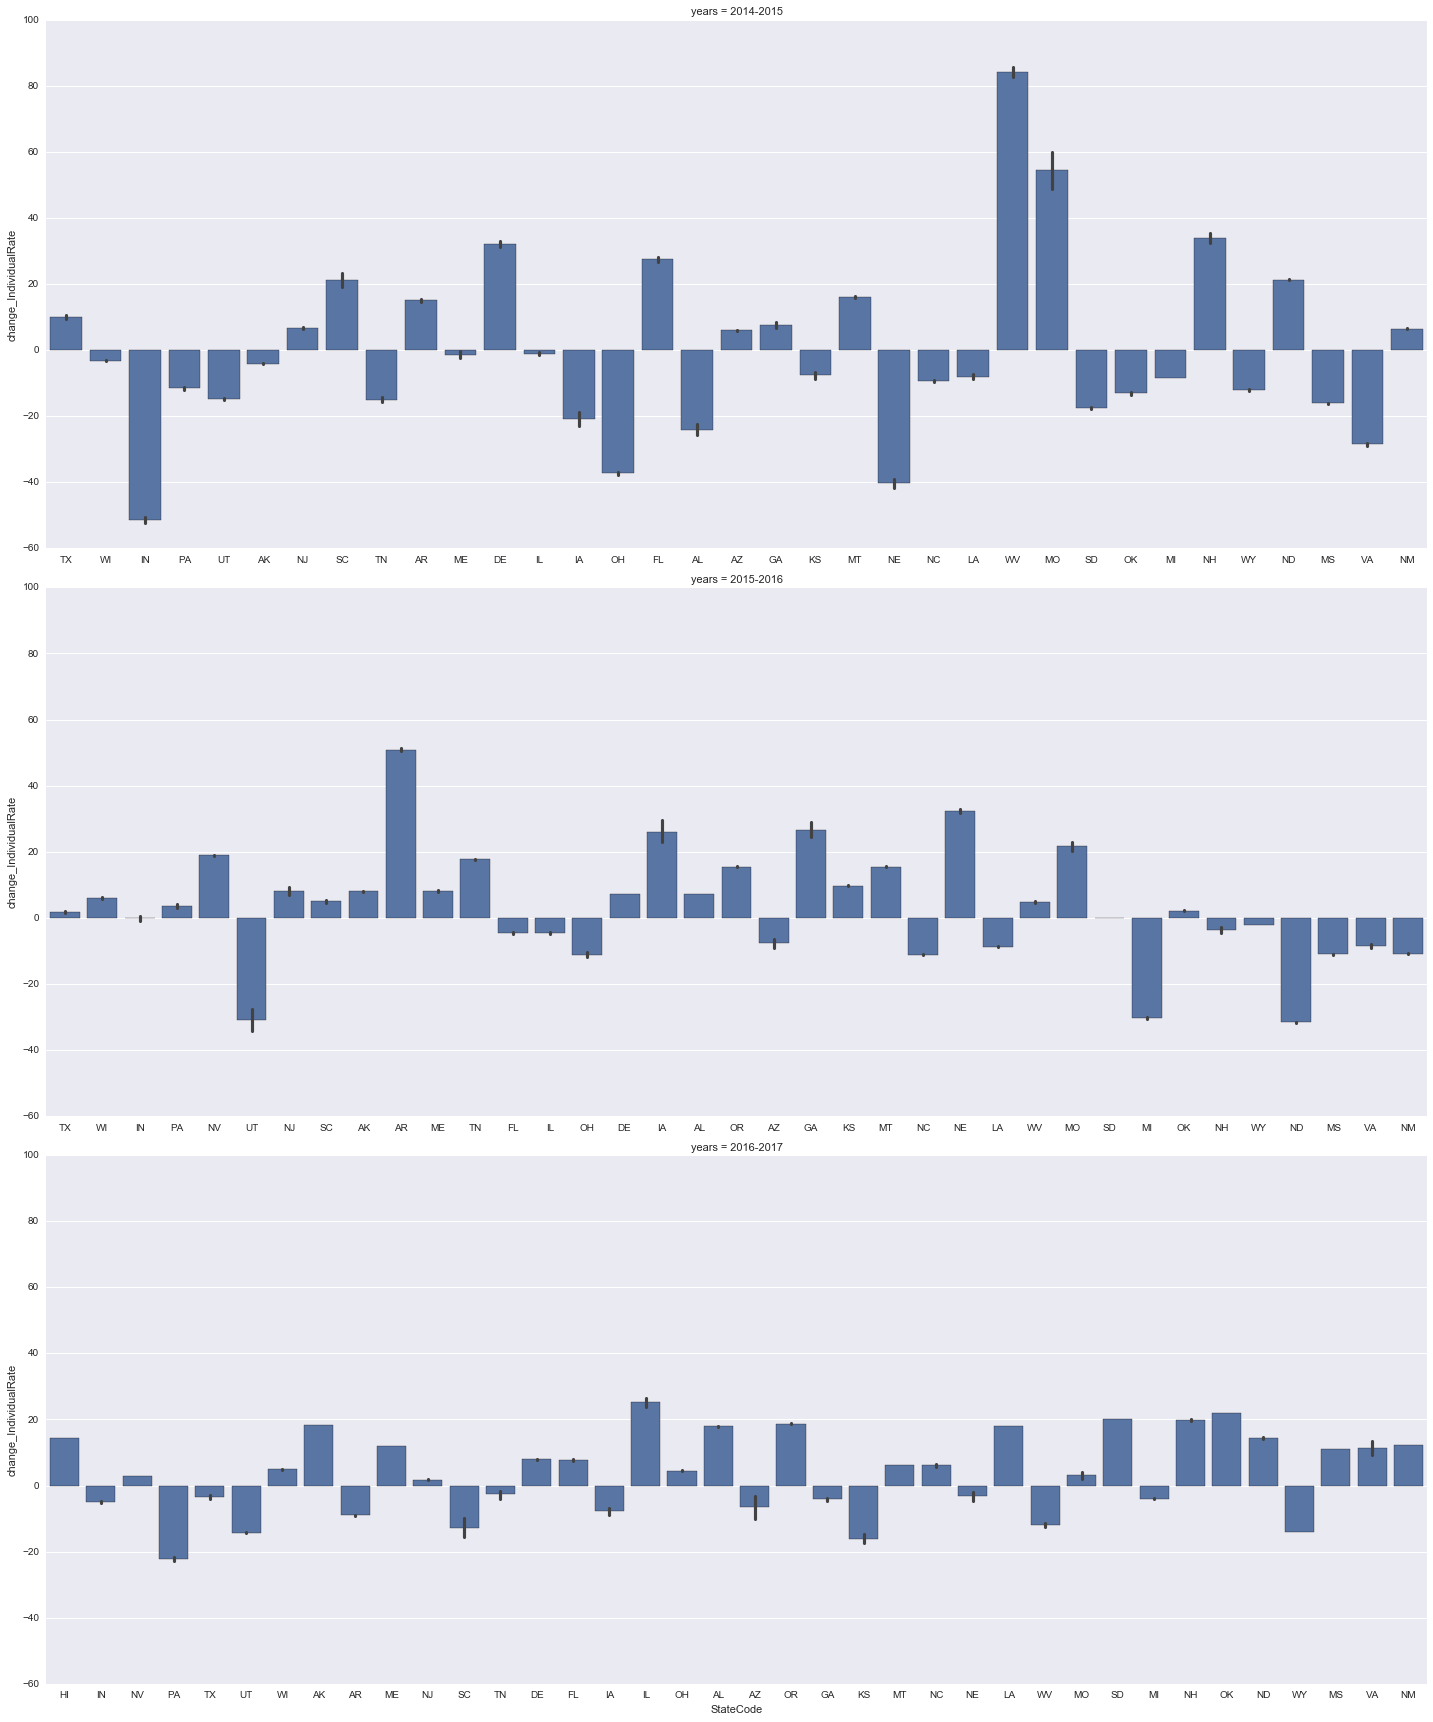

In [17]:
g = sns.FacetGrid(row='years', data=allYears[allYears.Age != 'Family Option'], size=8, aspect=2.5, sharex=False)
g.map(sns.barplot,'StateCode','change_IndividualRate')

By looking at rate changes by state, we've revealed the volatility in the rates -- some states have seen dramatic increases or decreases. It's interesting to note that changes in rates seems to be getting less pronounced as time has gone one.

## Rate Changes By Age And State

Now let's look at the changes by age and state. For simplicity, we'll bin the ages into larger groups: 0-30, 31-55, and 55+.

In [18]:
def binAge(age):
    if age.find('-') > -1:
        return '0-30'
    if age.find('and') > -1:
        return '55+'
    if age == 'Family Option':
        return 'Family Option'
    
    age = int(age)
    
    if age < 31:
        return '0-30'
    
    if age > 31 and age < 55:
        return '31-54'
    
    return '55+'

change1415['ageBin'] = change1415.Age.apply(binAge)
change1516['ageBin'] = change1516.Age.apply(binAge)
change1617['ageBin'] = change1617.Age.apply(binAge)

(-100, 100)

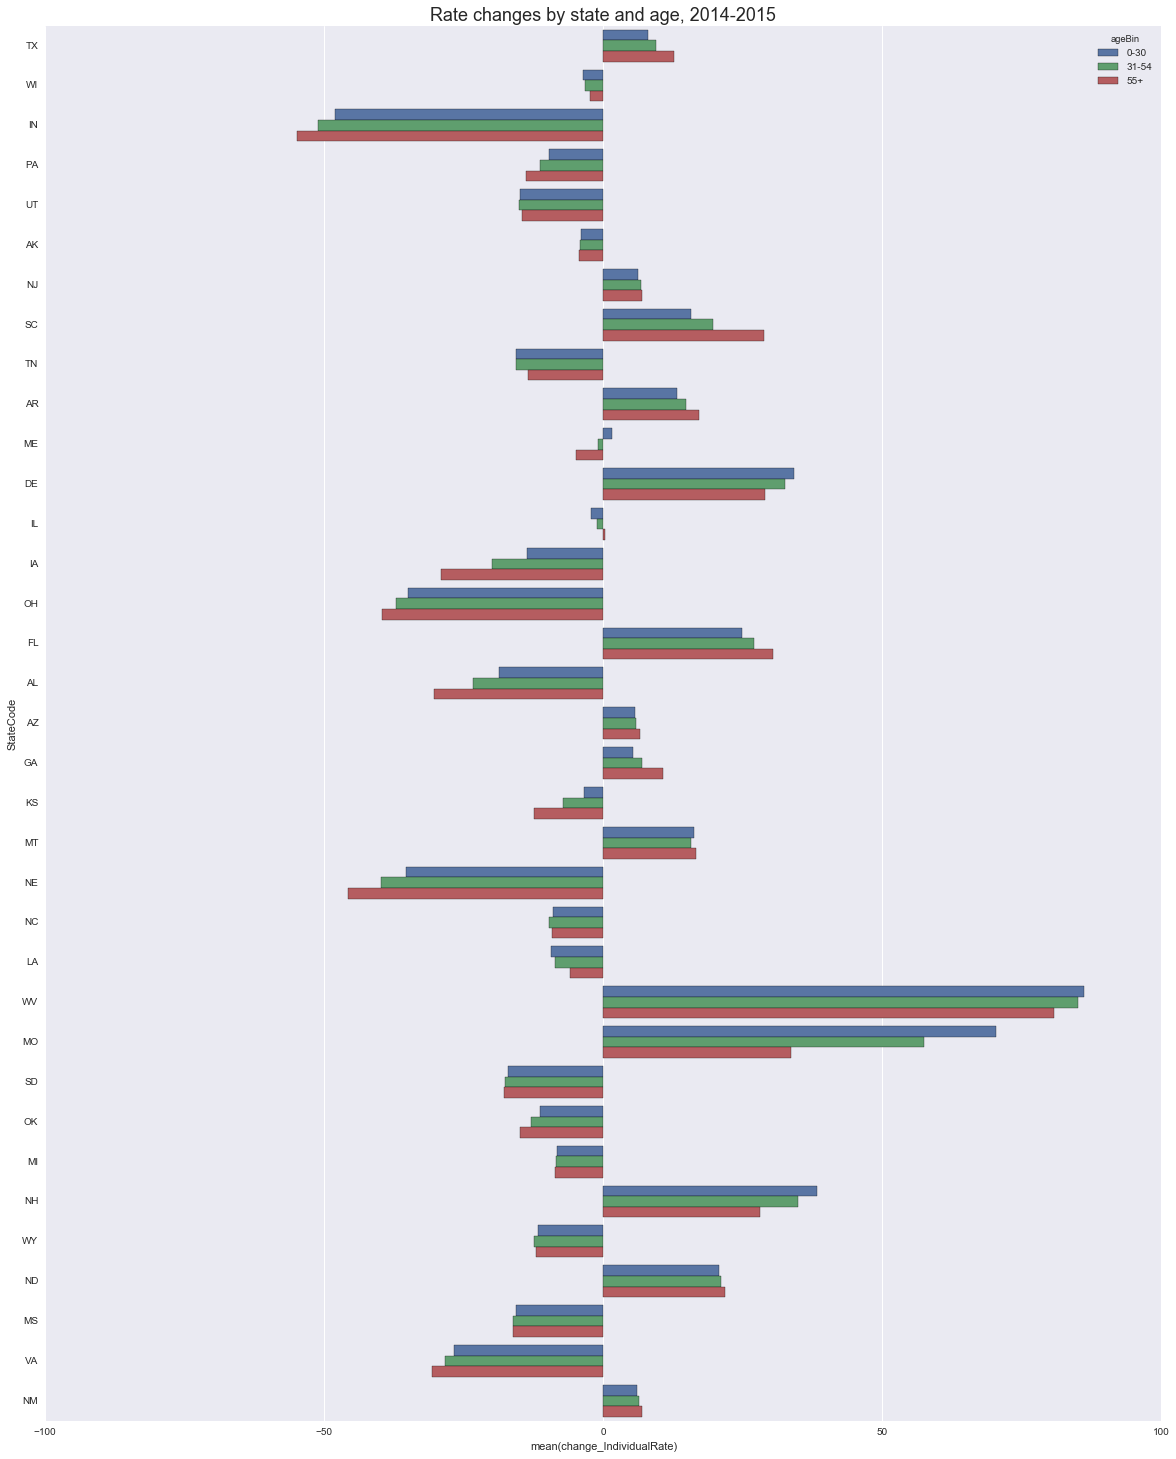

In [40]:
order = list(change1415.ageBin.unique())
fig, ax =plt.subplots(1,1, figsize=(20, 25))
sns.barplot(y='StateCode', x='change_IndividualRate', hue='ageBin', ci=None, hue_order=order, data=change1415)
ax.set_title('Rate changes by state and age, 2014-2015')
ax.set_xlim([-100, 100])

(-100, 100)

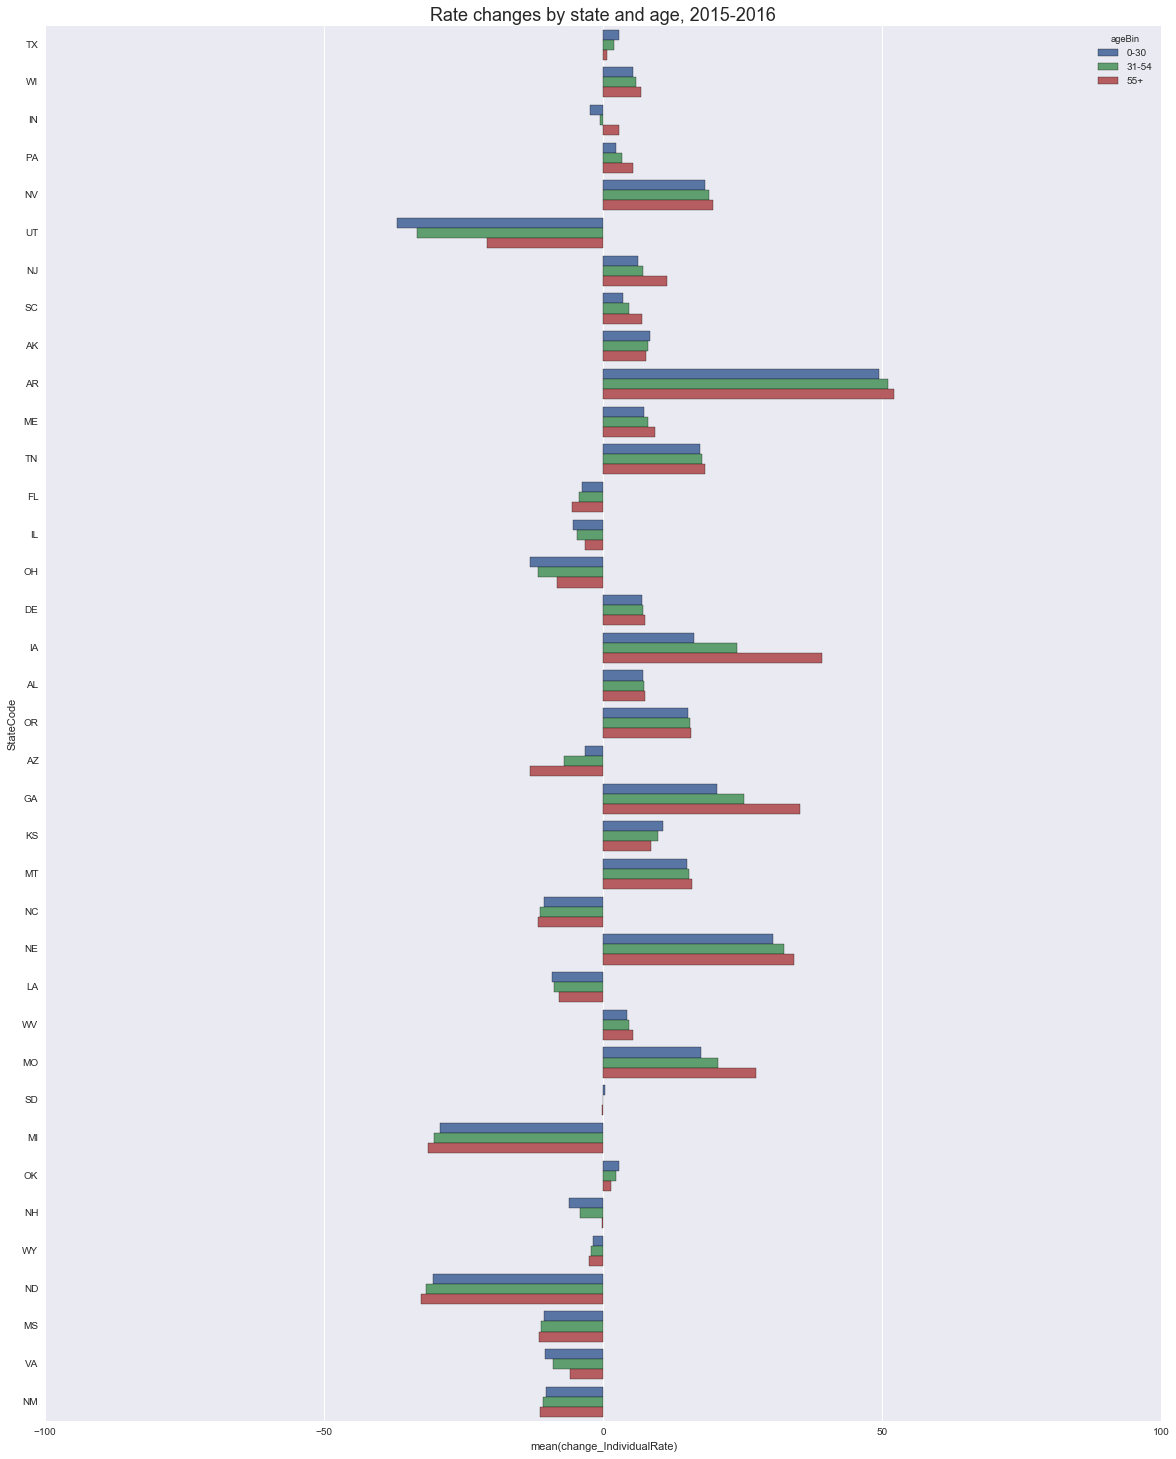

In [41]:
fig, ax =plt.subplots(1,1, figsize=(20, 25))
sns.barplot(y='StateCode', x='change_IndividualRate', hue='ageBin',hue_order=order, ci=None, data=change1516)
ax.set_title('Rate changes by state and age, 2015-2016')
ax.set_xlim([-100, 100])

(-100, 100)

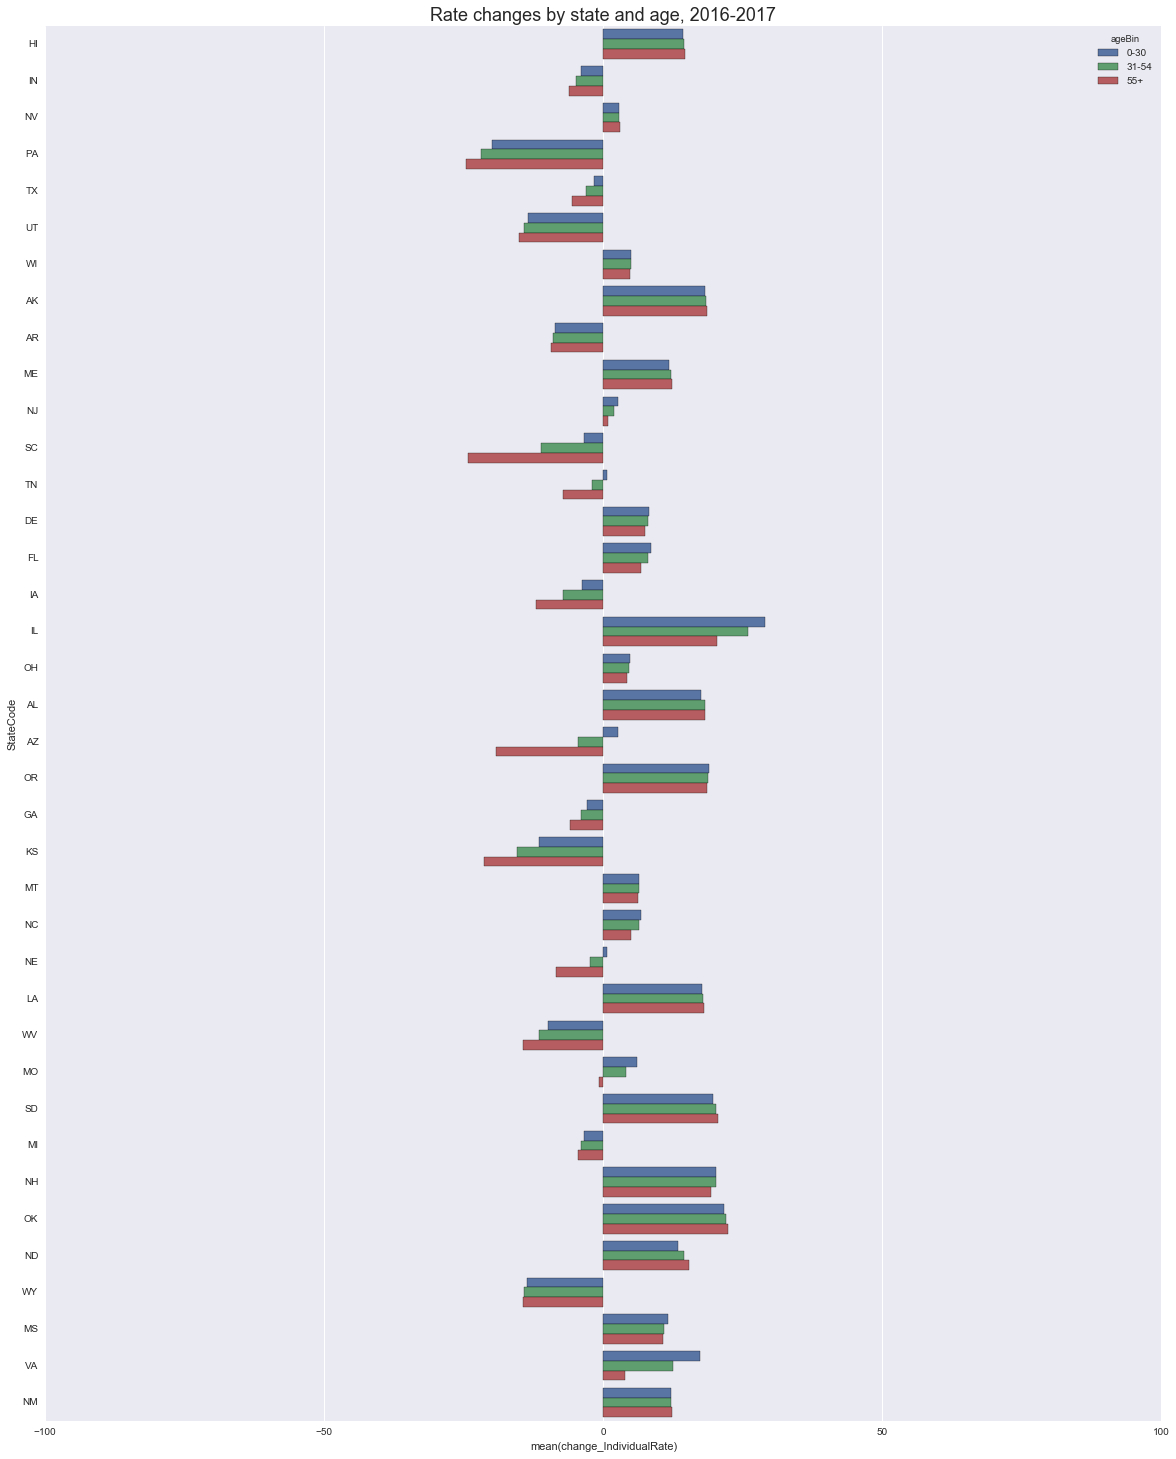

In [42]:
fig, ax =plt.subplots(1,1, figsize=(20, 25))
sns.barplot(y='StateCode', x='change_IndividualRate', hue='ageBin',hue_order=order, ci=None, data=change1617)
ax.set_title('Rate changes by state and age, 2016-2017')
ax.set_xlim([-100, 100])

Generally, for a given year and state, the rates for all the age bins move together -- they all increase or decrease. Additionally, though there are some exceptions, the age bins don't differ *that* much. For a given year and state, the rate changes for each bin are in the same ballpark. 

I started visualizing this data using maps, but found simpler graphs like the ones above easier to digest. Still, since I've written the function below to create maps, let's use it! 

In [67]:
import json
from folium.colormap import linear

us_states =  r'us-states.json'

geo_json_data = json.load(open(us_states))

fips = pd.read_csv('fips-codes.csv', header=None)
states = pd.DataFrame({'StateCode':pd.Series(fips[0].rename(columns={0:'StateCode'}).unique())})

def makeStateMap(df, dataCol):
    m = folium.Map(location=[43, -100], zoom_start=4)
    
    dataDict = df[df[dataCol].notnull()].set_index('StateCode')[dataCol]
    
    colormap = linear.RdBu.scale(
        -25,
        25)
    
    #we need to all the states in our dataset, or folium will throw an error. So we add the states that are missing
    statesToAppend =  pd.Series(index=[state for state in states.StateCode if state not in dataDict.index.values])
    
    #determine the colors for each state -- note we use black for 
    #states that were originally missing from our dataset 
    dataDict = dataDict.append(statesToAppend).fillna(-9999)
    color_dict = {key: colormap(dataDict[key]) if dataDict[key] != -9999 else '#000' for key in dataDict.keys()}
    
    folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: {
        'fillColor': color_dict[feature['id']],
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.9,
    }
).add_to(m)
    
    colormap.caption = 'Percentage Change'
    colormap.add_to(m)
    return m

We'll keep the maps pretty basic. We'll just plot the average change in rate for each state for each year.

In [68]:
df = change1415.groupby("StateCode").change_IndividualRate.mean().reset_index()
m = makeStateMap(df, 'change_IndividualRate')
m

In [69]:
df = change1516.groupby("StateCode").change_IndividualRate.mean().reset_index()
m = makeStateMap(df, 'change_IndividualRate')
m

In [72]:
df = change1617.groupby("StateCode").change_IndividualRate.mean().reset_index()
m = makeStateMap(df, 'change_IndividualRate')
m

A few things to note about the maps above:
* States in black are states we don't have data for.
* We're limiting the color scale from -25 to 25 to make it easier to distinguish states with rate increases from states with decreases. However, this comes at cost: the states that fall at the extreme ends of the colormaps may have experienced changes much more dramatic than +/-25%

